In [1]:
! pip install --upgrade sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "cats-dogs-full-training-result"

In [3]:
from sagemaker import image_uris

training_image = image_uris.retrieve(region=sess.boto_region_name, framework="image-classification")

print(training_image)
print(sess.boto_region_name)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
us-east-1


In [4]:
import os
import urllib.request
import boto3

s3_train_key = "cats-dogs-classification-full-training/train"
s3_validation_key = "cats-dogs-classification-full-training/validation"
s3_train = "s3://{}/{}/".format(bucket, s3_train_key)
s3_validation = "s3://{}/{}/".format(bucket, s3_validation_key)

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
# download to this current instance memory
download("https://lien-cats-dogs-bucket.s3.amazonaws.com/images_to_classify/cats_dogs_dataset_rec_train.rec")
download("https://lien-cats-dogs-bucket.s3.amazonaws.com/images_to_classify/cats_dogs_dataset_rec_val.rec")
#copy to s3 bucket
!aws s3 cp cats_dogs_dataset_rec_train.rec $s3_train --quiet
!aws s3 cp cats_dogs_dataset_rec_val.rec $s3_validation --quiet

print(s3_train)
print(s3_validation)

s3://sagemaker-us-east-1-409384357934/cats-dogs-classification-full-training/train/
s3://sagemaker-us-east-1-409384357934/cats-dogs-classification-full-training/validation/


In [5]:
deploy_amt_model = True

In [7]:
import sagemaker
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)
ic.set_hyperparameters(
    num_layers=18,
    use_pretrained_model = 1,
    image_shape="3,224,224",
    num_classes=2,
    num_training_samples=1000,
    mini_batch_size=64,
    epochs=5,
    learning_rate=0.01,
    top_k=2,
    precision_dtype="float32",
)
train_data = sagemaker.inputs.TrainingInput(
    s3_train,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}
ic.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: image-classification-2023-02-05-04-16-48-634


2023-02-05 04:16:48 Starting - Starting the training job...
2023-02-05 04:17:14 Starting - Preparing the instances for training.........
2023-02-05 04:18:32 Downloading - Downloading input data...
2023-02-05 04:19:02 Training - Downloading the training image...............
2023-02-05 04:21:33 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Feb  5 04:22:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|               

In [8]:
import time
from sagemaker.tuner import IntegerParameter, ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

job_name = "CAT-DOG-ic-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Tuning job name: ", job_name)

# Image Classification tunable hyper parameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/IC-tuning.html
hyperparameter_ranges = {
    "beta_1": ContinuousParameter(1e-6, 0.999, scaling_type="Auto"),
    "beta_2": ContinuousParameter(1e-6, 0.999, scaling_type="Auto"),
    "eps": ContinuousParameter(1e-8, 1.0, scaling_type="Auto"),
    "gamma": ContinuousParameter(1e-8, 0.999, scaling_type="Auto"),
    "learning_rate": ContinuousParameter(1e-6, 0.5, scaling_type="Auto"),
    "mini_batch_size": IntegerParameter(8, 64, scaling_type="Auto"),
    "momentum": ContinuousParameter(0.0, 0.999, scaling_type="Auto"),
    "weight_decay": ContinuousParameter(0.0, 0.999, scaling_type="Auto"),
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 1


hp_tuner = HyperparameterTuner(
    ic,
    "validation:accuracy",
    hyperparameter_ranges,
    max_jobs=max_jobs,
    max_parallel_jobs=max_parallel_jobs,
    objective_type="Maximize",
)

# Launch a SageMaker Tuning job to search for the best hyperparameters
hp_tuner.fit(inputs=data_channels, job_name=job_name)

INFO:sagemaker:Creating hyperparameter tuning job with name: CAT-DOG-ic-2023-02-05-04-26-52


Tuning job name:  CAT-DOG-ic-2023-02-05-04-26-52
.............................................................................................................................................!


In [9]:
# Print the location of the model data from the tuning job's best training (or the previous standlone training)
model_data = (hp_tuner.best_estimator() if deploy_amt_model else ic).model_data
print("***1.deploy_amt_model: ", deploy_amt_model)
print("***2.hp_tuner.best_estimator().model_data: ", hp_tuner.best_estimator().model_data)
print("***3.ic.model_data: ",ic.model_data)
print("***4.model_data: ",model_data)
# Prepare model channel in addition to train and validation
model_data_channel = sagemaker.inputs.TrainingInput(
    model_data,
    distribution="FullyReplicated",
    s3_data_type="S3Prefix",
    content_type="application/x-sagemaker-model",
)

data_channels = {"train": train_data, "validation": validation_data, "model": model_data_channel}


2023-02-05 04:35:29 Starting - Found matching resource for reuse
2023-02-05 04:35:29 Downloading - Downloading input data
2023-02-05 04:35:29 Training - Training image download completed. Training in progress.
2023-02-05 04:35:29 Uploading - Uploading generated training model
2023-02-05 04:35:29 Completed - Resource reused by training job: CAT-DOG-ic-2023-02-05-04-26-52-004-e1ceeaaf
***1.deploy_amt_model:  True

2023-02-05 04:35:29 Starting - Found matching resource for reuse
2023-02-05 04:35:29 Downloading - Downloading input data
2023-02-05 04:35:29 Training - Training image download completed. Training in progress.
2023-02-05 04:35:29 Uploading - Uploading generated training model
2023-02-05 04:35:29 Completed - Resource reused by training job: CAT-DOG-ic-2023-02-05-04-26-52-004-e1ceeaaf
***2.hp_tuner.best_estimator().model_data:  s3://sagemaker-us-east-1-409384357934/cats-dogs-full-training-result/output/CAT-DOG-ic-2023-02-05-04-26-52-003-4d03650b/output/model.tar.gz
***3.ic.model

In [11]:
incr_ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)
incr_ic.set_hyperparameters(
    num_layers=18,
    use_pretrained_model = 1,
    image_shape="3,224,224",
    num_classes=2,
    num_training_samples=1000,
    mini_batch_size=64,
    epochs=5,
    learning_rate=0.01,
    top_k=2,
)

incr_ic.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: image-classification-2023-02-05-04-54-30-629


2023-02-05 04:54:30 Starting - Starting the training job...
2023-02-05 04:54:58 Starting - Preparing the instances for training.........
2023-02-05 04:56:14 Downloading - Downloading input data...
2023-02-05 04:56:34 Training - Downloading the training image............
2023-02-05 04:58:45 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Feb  5 04:59:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                   

In [12]:
!pip3 install pillow --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


Cute_dog.jpg


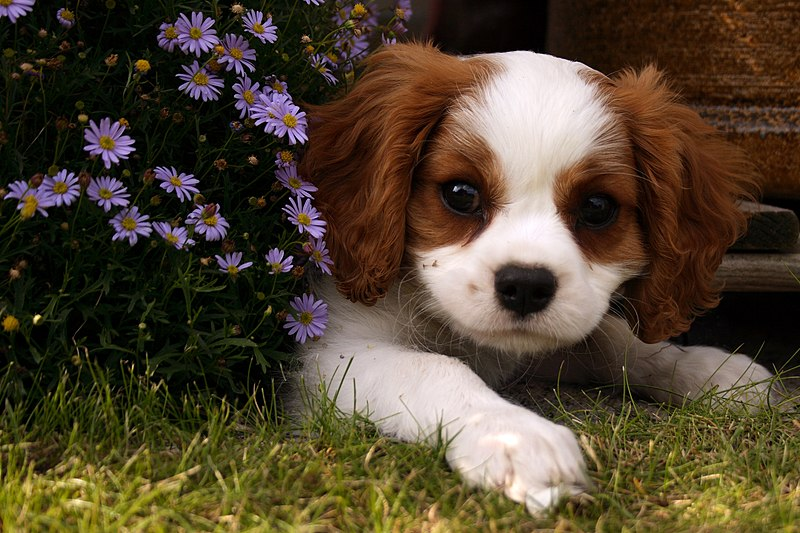

image pre-processing..
in: (800, 533)
out: (224, 224)


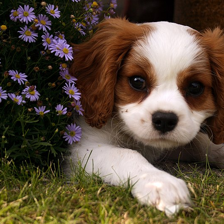

image pre-processing completed


In [20]:
from PIL import Image

NORMALIZED_WID = 224
NORMALIZED_HEI = 224

def calculate_image_crop_box_by_center(image):
    # box=(left, upper, right, lower)
    width, height = image.size # Output: (499, 375)
    print(f"in: {image.size}")
    if (width == height) and (height == NORMALIZED_HEI):
        return(0, 0 , NORMALIZED_WID, NORMALIZED_WID)
    center_x = width/2
    center_y = height/2
    if (width <= height):
        top = center_y - width/2
        left = 0
        return (left, top, left + width, top + width)
    else:
        top = 0
        left = center_x - height/2
        return (left, top, left + height, top + height)

def resize_scale_image_by_box(image, box):
    outImage = image.crop(box)
    outImage.thumbnail((NORMALIZED_WID, NORMALIZED_HEI))
    print(f"out: {outImage.size}")
    return outImage


image_url = "https://lien-cats-dogs-bucket.s3.amazonaws.com/test/Cute_dog.jpg"
download(image_url)

file_name = image_url.split("/")[-1]
image = Image.open(file_name)
print(file_name)

image.show()

print("image pre-processing..")
croppedBox = calculate_image_crop_box_by_center(image)
image = resize_scale_image_by_box(image, croppedBox)
image.show()
normalized_file_name = "normalized_cats_dogs.jpg"
image.save(normalized_file_name)
print("image pre-processing completed")

In [21]:
ic_classifier = incr_ic.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Creating model with name: image-classification-2023-02-05-13-11-25-797
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-02-05-13-11-25-797
INFO:sagemaker:Creating endpoint with name image-classification-2023-02-05-13-11-25-797


-----------!

In [22]:
import json
import numpy as np
from sagemaker.serializers import IdentitySerializer

with open(normalized_file_name, "rb") as f:
    payload = f.read()

ic_classifier.serializer = IdentitySerializer("image/jpeg")
result = json.loads(ic_classifier.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = [
    "cat",
    "dog",
]
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - dog, probability - 0.999991774559021


cat-1192026__340.jpg


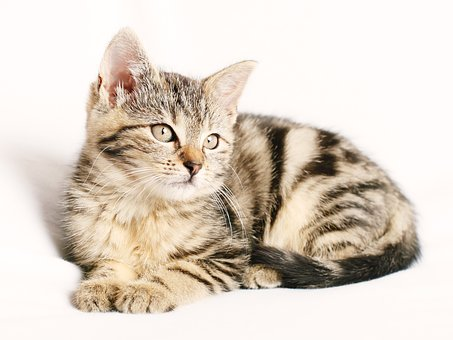

image pre-processing..
in: (453, 340)
out: (224, 224)


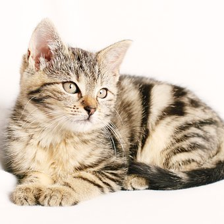

image pre-processing completed
Result: label - cat, probability - 0.9999037981033325


In [28]:
image_url = "https://lien-cats-dogs-bucket.s3.amazonaws.com/test/cat-1192026__340.jpg"
download(image_url)

file_name = image_url.split("/")[-1]
image = Image.open(file_name)
print(file_name)

image.show()

print("image pre-processing..")
croppedBox = calculate_image_crop_box_by_center(image)
image = resize_scale_image_by_box(image, croppedBox)
image.show()
normalized_file_name = "normalized_cats_dogs.jpg"
image.save(normalized_file_name)
print("image pre-processing completed")

ic_classifier.serializer = IdentitySerializer("image/jpeg")
result = json.loads(ic_classifier.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = [
    "cat",
    "dog",
]
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

In [29]:
ic_classifier.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: image-classification-2023-02-05-13-11-25-797
INFO:sagemaker:Deleting endpoint with name: image-classification-2023-02-05-13-11-25-797
